# IBM DATA SCIENCE PROFESSIONAL CERFICATE
### APPLIED DATA SCIENCE CAPSTONE
**BY: RISHI SAXENA**



# THE BATTLE OF NEIGHBORHOODS
This code endeavours to identify similar neighborhoods between Toronto and New York - the two major cities in the U.S. and Canada - using Machine Learning. This code adopts the use of the FourSquare API to fetch relevant information regarding the neighborhoods in the two cities.

Additionally, Folium library is used to create visualizations to present the results. 

### 1. DATA

In [1]:
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import folium 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

#### 1.1 Reading the Data
Using the borough and neighbourhood data of two cities - New York and Toronto. This data would be json format and it can be  easily transformed into a pandas dataframe (as shown in the following code). Only relevant data will be retained - such as borough, neighbourhood, latitude and longitude.

##### 1.1.1 New York Data
New York Data can be downloaded using the following link -\
https://cocl.us/new_york_dataset

In [2]:
with open('newyork_data.json') as raw:
    newyork_json = json.load(raw)

# relevant information is in 'features' key
newyork_json = newyork_json['features']
newyork_json[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [3]:
#let's make empty dataframe and put the useful information of json data into dataframe
cols = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
newyork_df = pd.DataFrame(columns = cols)
for data in newyork_json:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    newyork_df = newyork_df.append({'Borough': borough,'Neighborhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
newyork_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


##### 1.1.2 Toronto Data
Data for Toronto city needs to be generated using two different sources. The first source contains the Postal Code, borough and neighbourhood data, that can be scrapped from the following wikipedia page -\
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This data needs to be processed before proceeding with the machine learning algorith. Rows with missing data are dropped and neighborhoods are grouped together if they share the same postal code and borough. 

The second source contains the latitude and longitude data. This is critical for FourSquare API. The second set of data can be found using the following URL -
https://cocl.us/Geospatial_data

In [4]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(page, 'html.parser')

geo = pd.read_csv('Geospatial_Coordinates.csv')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

toronto_df = df.set_index('PostalCode').join(geo.set_index('Postal Code'))
toronto_df.reset_index(inplace=True)

toronto_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


#### 1.2 FOURSQUARE API

In [5]:
CLIENT_ID = 'QXZ3DNGR150U3WEPXTUKGD04YE3OGDEOPGMO22FRPBLLCSZI' # your Foursquare ID
CLIENT_SECRET = 'OECAYZU0YPZLZXL1UXY0QHYAQTV5FU5ZN2CZT3WSSZPBVGOD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [6]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [7]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighborhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighborhood'] = venues['Neighborhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighborhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighborhood', how = 'left')
    
    return onehot_coded_df

In [8]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

##### 1.2.1 NEW YORK CITY

In [9]:
try:
    df1 = pd.read_csv('New_York_venue.csv')
except:
    df1 = return_venues_for_boroughs(newyork_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York_venue.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head()

Shape data is:  (306, 488)


,Borough,Neighborhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mi

##### 1.2.2 TORONTO

In [10]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

Shape data is:  (103, 334)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Sho

* Now our data is ready to process. We've 488 columns in New York data and 334 columns in Toronto city data.
* Other than these columns ('Borough', 'Neighborhood', 'Latitude', 'Longitude') of New York city data are nearby venues of corresponding Neighbourhood.
* Other than these columns ('Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude',) of Toronto city data are nearby venues of corresponding Neighbourhood.

### 2. EXPLORATORY DATA ANALYSIS (EDA)
The following analysis identifies the common columns in the two dataframes.

**Note:** 'Borough', 'Neighbourhood', and 'Latitude' columns of New York data and 'Postal Code', 'Borough', 'Neighbourhood', and 'Latitude' of Toronto city data will not be counted, when we'll be finding the common columns of both data.

**Common Venue Categories**

In [11]:
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are       :301
Number of different venue categories in New York city are: 183
Number of different venue catehories in Toronto city are : 28


Venn Diagram showing the shared venue categories between New York and Toronto:


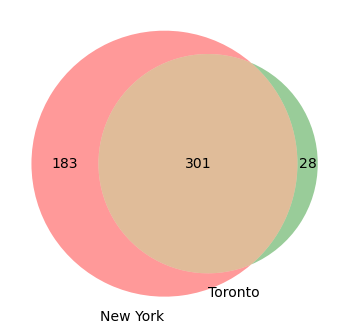

In [12]:
print('Venn Diagram showing the shared venue categories between New York and Toronto:')
cl1 = set(df1.columns[4:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York', 'Toronto'])

for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(14)
plt.show()

In [13]:
comm_col = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Original New York dataframe: {}. Original Toronto dataframe: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('Condensed New York dataframe: {}. Condensed Toronto dataframe: {}'
      .format(df1.shape, df2.shape))

Original New York dataframe: (306, 488). Original Toronto dataframe: (103, 334)
Condensed New York dataframe: (306, 305). Condensed Toronto dataframe: (103, 306)


### 3. SIMILAR LOCATIONS IN THE TWO CITIES
Using Cosine Similarity, the most similar locations between the two cities can be identified.

The following analysis assumes that a person in currently living in New Brighton, Staten Island, New York. The aim is to find the most common boroughs in Toronto for this person.

In [14]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [15]:
index = df1.loc[(df1['Borough'] == 'Staten Island') 
                & (df1['Neighborhood'] == 'New Brighton')].index.values.astype(int)[0]
lat = df1.loc[index]['Latitude']
lon = df1.loc[index]['Longitude']
print('Index    :{}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index    :1
Latitude : 40.64061455913511
Longitude: -74.08701650516626


In [16]:
newyork_data = df1.loc[:,comm_col] # selecting only common venues
toronto_data = df2.loc[:,comm_col] # selecting only common venues

# converting into numpy ndarray
X1 = newyork_data.values
X2 = toronto_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 301)
Shape of X2: (103, 301)


Find similar boroughs in Toronto using cosing similarity:

In [17]:
a = np.matmul(X1[index], X2.T)

aa = np.argsort(-a)[0:7] 
my_borough = df2.iloc[aa, :]
print(my_borough.shape)
my_borough.head()

(7, 306)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Roo

In [18]:
# for tooltip of map
c = return_ordered_num(7)

current_location_popup = 'New Brighton, Staten Island, New York'
label1 = folium.Popup(current_location_popup, parse_html=True)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                    popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                    fill = True, tooltip = 'current location').add_to(my_map)

# add markers to map
for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                     my_borough['Neighborhood'], c):
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                  tooltip = priority, parse_html=False).add_to(my_map)
    
my_map

### 4. FINAL MODEL

The following fundtion follows the above mentioned process to determine the most similar neighborhood in the corresponding city. The arguments are as follows -
1. Current City - the city of the source
2. Current Borough - the borough of the source in the city
3. Current Neighborhood - the neighborhood of the source in the borough
4. Number of similar neighborhoods in the other city

In [19]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighborhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    return my_map

**From New York to Toronto:**

In [20]:
most_similar_borough(current_city = 'New York', current_borough = 'Bronx',
                     current_neigh = 'Riverdale', n_most_similar = 7)

**From Toronto to New York:**

In [23]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Etobicoke',
                     current_neigh = 'Alderwood, Long Branch', n_most_similar = 7)